In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-15 11:34:41.013601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 11:34:41.013617: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.LinearModel import LinearModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
deep_learner = LinearModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 40,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.LinearModel()

Epoch 1/40
 1/66 [..............................] - ETA: 8s - loss: 0.0194

2022-03-15 11:34:44.361404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 11:34:44.361867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 11:34:44.361921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-15 11:34:44.361965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-15 11:34:44.362007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0240
Epoch 2/40
66/66 [==============================] - 0s 694us/step - loss: 0.0280 - val_loss: 0.0186
Epoch 3/40
66/66 [==============================] - 0s 721us/step - loss: 0.0228 - val_loss: 0.0151
Epoch 4/40
66/66 [==============================] - 0s 727us/step - loss: 0.0193 - val_loss: 0.0128
Epoch 5/40
66/66 [==============================] - 0s 810us/step - loss: 0.0168 - val_loss: 0.0111
Epoch 6/40
66/66 [==============================] - 0s 742us/step - loss: 0.0150 - val_loss: 0.0099
Epoch 7/40
66/66 [==============================] - 0s 759us/step - loss: 0.0136 - val_loss: 0.0090
Epoch 8/40
66/66 [==============================] - 0s 715us/step - loss: 0.0126 - val_loss: 0.0084
Epoch 9/40
66/66 [==============================] - 0s 753us/step - loss: 0.0119 - val_loss: 0.0079
Epoch 10/40
66/66 [==============================] - 0s 603us/step - loss: 0.0113 - val_loss: 0.0075
Epoch 11/40


In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

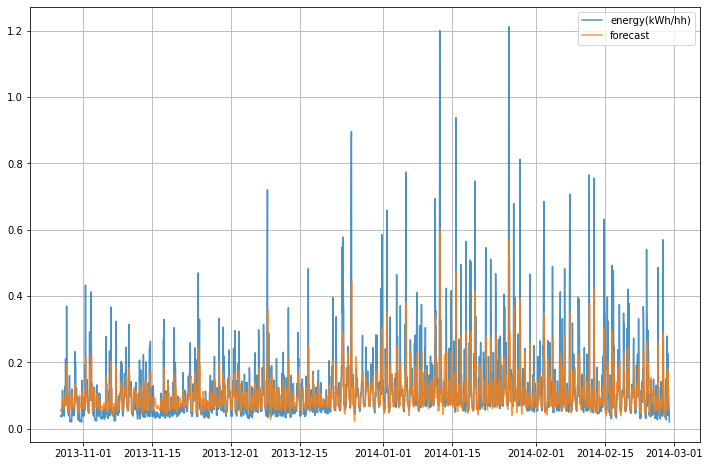

In [9]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_233786/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


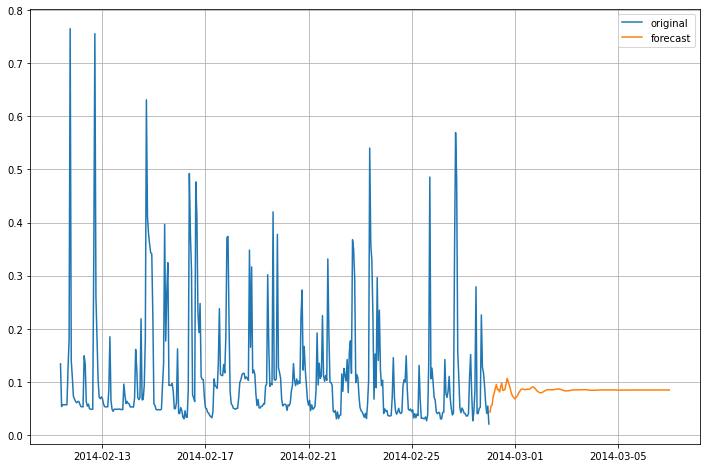

In [10]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [11]:
deep_learner.evaluateMSE()

0.006605635054534823

In [12]:
deep_learner.evaluateRMSE()

0.08127505801003665

In [13]:
deep_learner.evaluateMAE()

0.04065972742391261

In [14]:
deep_learner.evaluateMAPE()

37.59908813473977

In [15]:
yhat =deep_learner.predict()

In [16]:
yhat

[0.056290336,
 0.05237335,
 0.052713476,
 0.053014204,
 0.05724677,
 0.06090957,
 0.06663788,
 0.070379086,
 0.074239284,
 0.086698726,
 0.09396695,
 0.078331634,
 0.07134317,
 0.07045327,
 0.06509066,
 0.06211345,
 0.064541094,
 0.062323056,
 0.064651564,
 0.06843327,
 0.08265294,
 0.09755379,
 0.080091,
 0.07952874,
 0.083374396,
 0.12855548,
 0.09375428,
 0.07279718,
 0.07650695,
 0.072951846,
 0.19399515,
 0.13735059,
 0.10562468,
 0.102399305,
 0.09154027,
 0.06289655,
 0.05946697,
 0.051426917,
 0.050187163,
 0.048097488,
 0.059763625,
 0.063862756,
 0.059642315,
 0.08220452,
 0.11290004,
 0.06901016,
 0.06143458,
 0.06523894,
 0.06728532,
 0.06291494,
 0.06825684,
 0.065936774,
 0.08174968,
 0.09801006,
 0.07903987,
 0.06816081,
 0.07837325,
 0.10093506,
 0.08143927,
 0.07123391,
 0.066618636,
 0.06597179,
 0.061889317,
 0.06135298,
 0.07142704,
 0.06227155,
 0.07142745,
 0.071949825,
 0.06189537,
 0.07916651,
 0.13638571,
 0.08751193,
 0.07950477,
 0.12343801,
 0.11100055,
 0.0